In [14]:
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [2]:
vgg = VGG16(include_top=False)

In [3]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [5]:
face_tracker = build_model()

In [6]:
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

* **`Images`:**

In [8]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
test_images  = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
val_images   = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)

In [9]:
def load_img(file):
    byte_img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
train_images = train_images.map(load_img)
train_images = train_images.map(lambda img: tf.image.resize(img, (120, 120)))
train_images = train_images.map(lambda img: img/255.)

In [11]:
test_images = test_images.map(load_img)
test_images = test_images.map(lambda img: tf.image.resize(img, (120, 120)))
test_images = test_images.map(lambda img: img/255.)

In [12]:
val_images = val_images.map(load_img)
val_images = val_images.map(lambda img: tf.image.resize(img, (120, 120)))
val_images = val_images.map(lambda img: img/255.)

* **`Labels`:**

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [16]:
# loading
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)

# mapping: load_labels
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
# Final datasets:

# train:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

# test:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

# val:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

* **`roughwork` predictions before model training:**

In [19]:
X, y = train.as_numpy_iterator().next()

In [20]:
X.shape

(8, 120, 120, 3)

In [21]:
classes, coords = face_tracker.predict(X)
classes, coords

1/1 [==============================] - 6s 6s/step


(array([[0.53622824],
        [0.576071  ],
        [0.58945495],
        [0.56317836],
        [0.5456299 ],
        [0.5685137 ],
        [0.55703914],
        [0.57120353]], dtype=float32),
 array([[0.6095738 , 0.35149688, 0.56342566, 0.41515654],
        [0.69287825, 0.34921786, 0.56753916, 0.40957657],
        [0.64706063, 0.3123788 , 0.5829599 , 0.43730795],
        [0.6251256 , 0.36461958, 0.5474446 , 0.4150628 ],
        [0.63513726, 0.3723813 , 0.53968096, 0.43548992],
        [0.6389125 , 0.35453114, 0.5431645 , 0.40807375],
        [0.65106857, 0.37602043, 0.5454431 , 0.4098037 ],
        [0.6848797 , 0.40236834, 0.57085824, 0.40227005]], dtype=float32))

* **Defining `losses` and `optimizers`:**

In [23]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [24]:
batches_per_epoch

630

* **`Localization Loss`:**

In [25]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

* **`Class Loss`:**

In [26]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

* **Testing Loss metrics:**

In [27]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.502864>

In [29]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.57413846>

In [31]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.502864>

* **Custom Model:**

In [32]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [34]:
model = FaceTracker(face_tracker)
model.compile(opt, classloss, regressloss)

* **Training:**

In [35]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
history = model.fit(train,
                    epochs = 30, 
                    validation_data = val,
                    callbacks = [tensorboard_callback])

Epoch 1/30
630/630 [==============================] - 58s 80ms/step - total_loss: 0.3883 - class_loss: 0.0961 - regress_loss: 0.3403 - val_total_loss: 0.1487 - val_class_loss: 0.0119 - val_regress_loss: 0.1427
Epoch 2/30
630/630 [==============================] - 55s 81ms/step - total_loss: 0.0976 - class_loss: 0.0299 - regress_loss: 0.0826 - val_total_loss: 0.0338 - val_class_loss: 0.0035 - val_regress_loss: 0.0321
Epoch 3/30
630/630 [==============================] - 57s 84ms/step - total_loss: 0.0608 - class_loss: 0.0205 - regress_loss: 0.0506 - val_total_loss: 0.0429 - val_class_loss: 0.0042 - val_regress_loss: 0.0408
Epoch 4/30
630/630 [==============================] - 58s 84ms/step - total_loss: 0.0551 - class_loss: 0.0167 - regress_loss: 0.0468 - val_total_loss: 0.0279 - val_class_loss: 0.0052 - val_regress_loss: 0.0253
Epoch 5/30
630/630 [==============================] - 59s 85ms/step - total_loss: 0.0345 - class_loss: 0.0117 - regress_loss: 0.0287 - val_total_loss: 0.0180 - 

In [40]:
history.history

{'total_loss': [0.7070997357368469,
  0.08193756639957428,
  0.47331082820892334,
  0.442219614982605,
  0.018704617395997047,
  0.005374705418944359,
  1.5474708080291748,
  0.02058652974665165,
  0.006257086992263794,
  0.009209863841533661,
  0.004602562636137009,
  0.005123309791088104,
  0.01210607960820198,
  0.003671094076707959,
  0.0011856548953801394,
  0.0013841725885868073,
  0.0018623359501361847,
  0.0008079595863819122,
  0.001394877559505403,
  0.00199553812853992,
  0.0009317309595644474,
  0.0006557807791978121,
  0.0007322736782953143,
  0.0019712354987859726,
  0.0008339052437804639,
  0.0007044936646707356,
  0.0003081443428527564,
  0.0012285353150218725,
  0.00017809898417908698,
  0.000293161254376173],
 'class_loss': [0.30726227164268494,
  0.01826103962957859,
  0.34571048617362976,
  0.3192841708660126,
  5.194150435272604e-05,
  6.407503860828001e-07,
  0.6223909258842468,
  0.0008025433635339141,
  0.0005769484560005367,
  0.003913131542503834,
  5.60287617

* **Performance:**

In [42]:
import matplotlib.pyplot as plt

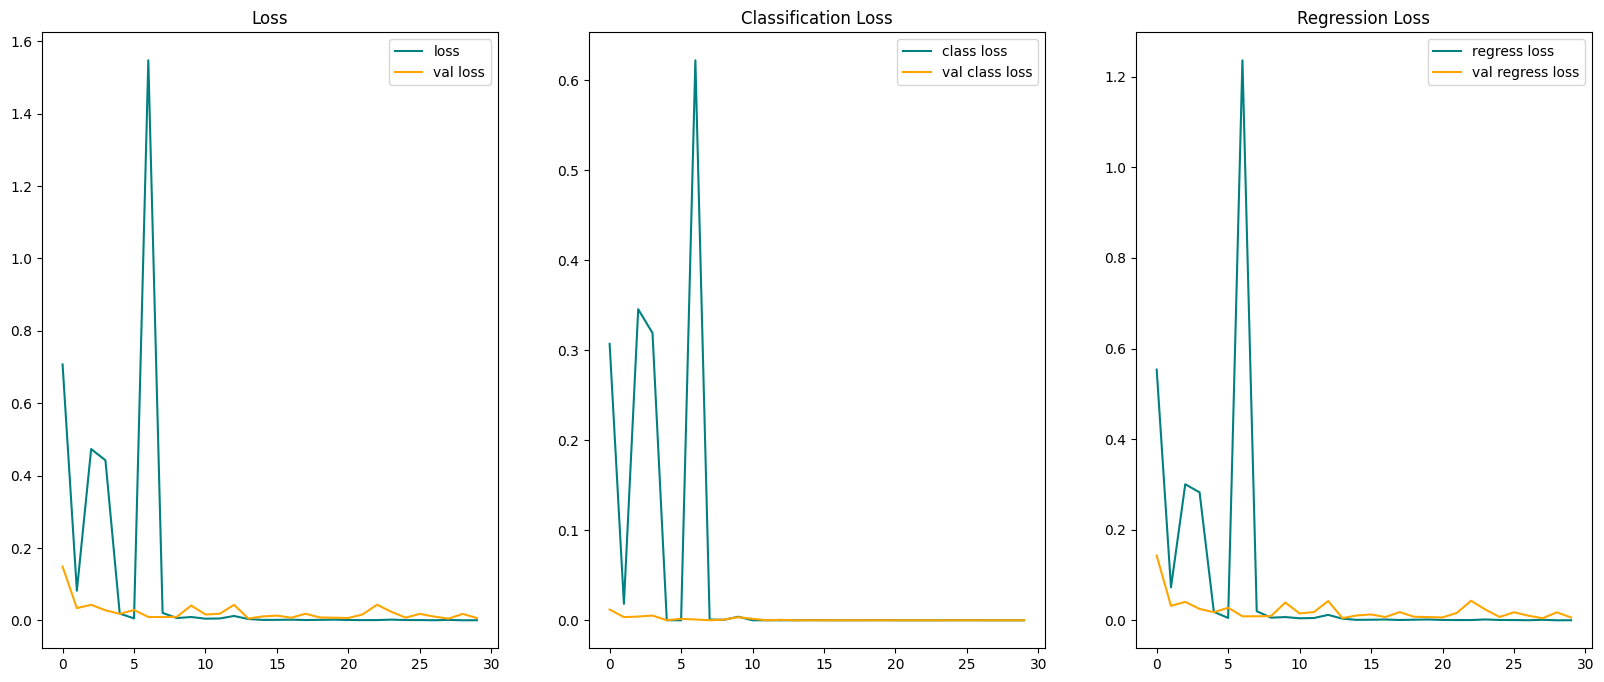

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(20,8))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

* **Making predictions:**

In [48]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = face_tracker.predict(test_sample[0])

1/1 [==============================] - 0s 33ms/step


In [49]:
yhat

[array([[1.0000000e+00],
        [1.0000000e+00],
        [9.9999988e-01],
        [9.9999750e-01],
        [1.0000000e+00],
        [3.3031091e-07],
        [9.9999952e-01],
        [1.1582476e-04]], dtype=float32),
 array([[3.5897499e-01, 1.0281747e-01, 9.3944365e-01, 8.9608890e-01],
        [3.3561853e-01, 1.9104338e-01, 8.1292313e-01, 8.2171780e-01],
        [1.8339665e-03, 1.7880805e-01, 2.9938170e-01, 7.3130769e-01],
        [4.8525271e-01, 2.4309124e-01, 7.7986974e-01, 6.2017530e-01],
        [6.4985561e-01, 1.7473558e-01, 9.9510729e-01, 7.9163748e-01],
        [2.5981138e-04, 4.8614811e-04, 4.9674051e-04, 6.9130101e-04],
        [4.7814036e-03, 2.4722111e-01, 3.2692406e-01, 7.7000368e-01],
        [2.7807290e-03, 3.1296932e-03, 3.4456404e-03, 4.9382430e-03]],
       dtype=float32)]

* **`Saving` model:**

In [58]:
face_tracker.save('FaceDetectionModel.keras')

In [57]:
!nvidia-smi

Sun Jun  9 17:42:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   66C    P8              6W /   60W |    3386MiB /   4096MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----